# 章節 8：觀察者偏誤（Observer Bias）

## 8.6 納入不確定性

先預備上章節的程式碼，程式碼後正文開始。

In [32]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
import thinkbayes as tb

OBSERVED_GAP_TIMES = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]

passenger_data = [
    (17, 4.6, 9),
    (22, 1.0, 0),
    (23, 1.4, 4),
    (18, 5.4, 12),
    (4, 5.8, 11),
]


def plot_dist(dist, c=None):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y, c=c)

class TruthGaps(tb.Pmf):
    
    def __init__(self, gaps, x=np.linspace(0.1, 20, 200)):
        super().__init__(x)
        self.kde = gaussian_kde(gaps_min)
        self.make_pmf(x)
        
    def make_pmf(self, x):
        for interval in x:
            self.Set(interval, self.evaluate(interval))
        
        self.Normalize()
        

    def evaluate(self, x):
        return self.kde(x)[0]


def BiasPmf(pmf):
    # pmf 是真實資料的分佈
    new_pmf = pmf.Copy()
    
    # 在迴圈裡面，我們對每個數值的機率乘上數值本身，x，也就是被觀察到的可能性與 x 成正比
    for x, p in pmf.Items():
        new_pmf.Mult(x, x)
        
    # 正規化
    new_pmf.Normalize()
    
    #new_pmf 是乘客偏差的分佈
    return new_pmf

def MakeRange(low, high):
    sec = range(low, int(high*60)+1) # 每秒
    return np.array(sec)/60


def MakeUniformPmf(low, high):
    # low, high 為均勻分佈的範圍（包含兩端點）
    pmf = tb.Pmf()
    for x in MakeRange(low, high): # 產生所有可能的時間數值（分鐘）
        pmf.Set(x, 1)
    
    pmf.Normalize()
    return pmf


def PmfOfWaitTime(pmf_zb):
    
    # metapmf 將每個均勻分佈對應其班距的機率
    metapmf = tb.Pmf()
    for gap, prob in pmf_zb.Items():
        uniform = MakeUniformPmf(0, gap) # 產生均勻分佈
        metapmf.Set(uniform, prob)
    
    # 在 5.6 小節看到，用 MakeMixture 計算混合體
    pmf_y = tb.MakeMixture(metapmf)
        
    return pmf_y


class WaitTimeCalculator(object):
    
    def __init__(self, pmf_z):
        # pmf_z 是真實班距的分佈
        self.pmf_z = pmf_z
        
        # pmf_zb 是觀察者偏誤的班距分佈
        self.pmf_zb = BiasPmf(pmf_z)
        
        # pmf_y 是等待時間的分佈
        self.pmf_y = PmfOfWaitTime(self.pmf_zb)
        
        # pmf_y 是經過時間的分佈，跟等待時間分佈等同
        self.pmf_x = self.pmf_y.Copy()

def RemoveNegatives(pmf):
    for val in pmf.Values():
        if val < 0:
            pmf.Remove(val) # 做 dictionary 的移除 key 操作
    pmf.Normalize()


    
def PredictWaitTime(pmf_zb, pmf_x):
    # 減號運算子會呼叫 Pmf.__sub__ 的方法
    # Pmf.__sub__ 會找出所有 zb 和 x 數值的相減配對，並將其對應的相乘機率加總
    pmf_y = pmf_zb - pmf_x
    
    # pmf_y 不可能會有負的數值。例如班距為 5 分鐘，你不可能等超過 5 分鐘車才來。（除非你等下一班）
    # RemoveNegatives 就是移除 pmf_y 分佈中負的數值並且重新正規化
    RemoveNegatives(pmf_y)
    return pmf_y



class Elapsed(tb.Suite):
    
    def Likelihood(self, data, hypo):
        lam, num_passengers = data # 將資料拆解(unpacking)
        time_elapsed = hypo
        # 似然性函數為 Poisson 分佈
        # 意義為在不同經過時間看到 num_passengers 數量的機率
        like = tb.EvalPoissonPmf(num_passengers, time_elapsed*lam) 
        #print(data, hypo, like)
        return like
    

class ElapsedTimeEstimator(object):
    
    def __init__(self, wtc, lam, num_passengers):
        # wtc: 上方的 WaitTimeCalculator 物件
        # lam: 乘客抵達頻率（人/秒）
        # num_passengers: 月台乘客數
        
        # x 的先驗分佈，就是來自 WaitTimeCalculator 的 pmf_x
        self.prior_x = Elapsed(wtc.pmf_x)
        
        # x 的後驗分佈
        self.post_x = self.prior_x.Copy()
        
        # 這邊的資料是由 (乘客到達頻率, 目前月台乘客數) 所構成
        self.post_x.Update((lam, num_passengers)) # 參考 Elapsed 類別的 Likelihood 方法
        
        # y = zb - x
        self.pmf_y = PredictWaitTime(wtc.pmf_zb, self.post_x)

        
class ArrivalRate(tb.Suite):
    
    def Likelihood(self, data, hypo):
        lam = hypo
        y, k = data
        like = tb.EvalPoissonPmf(k, lam*y)
        return like        

    
class ArrivalRateEstimator(object):
    
    def __init__(self, passenger_data):
        low, high = 0.1, 5
        n = 51
        
        # lam 用均勻分佈表示 
        hypos = np.linspace(low, high, n)
        
        self.prior_lam = ArrivalRate(hypos)
        
        self.post_lam = self.prior_lam.Copy()
        
        # 用資料更新先驗分佈，產生後驗分佈 post_lam
        for k1, y, k2 in passenger_data:
            self.post_lam.Update((y, k2))

  
gaps_min = np.array(OBSERVED_GAP_TIMES)/60.0
z = TruthGaps(gaps_min)        
wait_time = WaitTimeCalculator(z)

# lam 每分鐘兩人 = 每秒 2.0/60 人
#ete = ElapsedTimeEstimator(wait_time, lam=2.0/60, num_passengers=15)
are = ArrivalRateEstimator(passenger_data) 

每當分析的其中一輸入有不確定性，我們可以考慮下面流程：

1. 將不確定的數值取一個固定的數值做分析（此例為 λ）
1. 計算不確定參數的分佈
1. 對每個參數做分析，並且產生一組預測分佈
1. 計算預測分佈的混合體，根據不同參數的機率做加權

步驟 1 和 2 目前已經完成。這邊用 WaitMixtureEstimator 類別完成步驟 3 和 4。

In [45]:
class WaitMixtureEstimator(object):
    
    def __init__(self, wtc, are, num_passengers=15):
        self.metapmf = tb.Pmf()
        
        for lam, prob in sorted(are.post_lam.Items()):
            # 對每個 lam 計算其經過時間分佈以及等待時間分佈
            ete = ElapsedTimeEstimator(wtc, lam=lam, num_passengers=num_passengers)
            
            # ete.pmf_y 為對某個 lam 的等待時間分佈
            self.metapmf.Set(ete.pmf_y, prob)
            
        self.mixture = tb.MakeMixture(self.metapmf)

# wait_time 是 WaitTimeCalculator 物件包含 zb 分佈
# are 是 ArrivalTimeEstimator 佈建包含 lam 分佈
wme = WaitMixtureEstimator(wait_time, are)

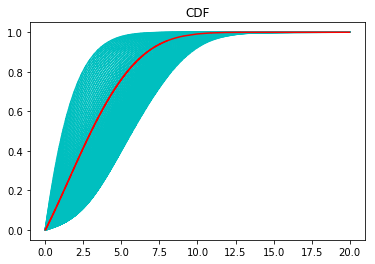

In [46]:
for pmf, prob in wme.metapmf.Items():
    plot_dist(pmf.MakeCdf(), c='c')

plot_dist(wme.mixture.MakeCdf(), c='r')
plt.title("CDF")
plt.show()

上圖為所有 lam 產生 CDF 的結果。青綠色的背景為各個 lam 的 CDF。紅色為這些 CDF 的混合體。

其實這非常接近用單一 lam 估計產生的結果，所以在真實情況下，不一定需要將不確定性納入考慮。

普遍來說，若系統的響應是非線性的，則考慮不確定性很重要；例如輸入有微小的改變造成輸出巨大的變化。

這章的例子來說，lam 後驗的變化對於系統的影響很小，系統響應近似為線性。